In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
# using Interpolations
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
params = Knet.params

params (generic function with 2 methods)

In [3]:
function resize_gray_image_tensor(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

function resize_MNIST(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img'), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

resize_MNIST (generic function with 3 methods)

In [4]:
xtrn,_ = MNIST.traindata()
xtst,_ = MNIST.testdata()
xtrn = Array{Float64, 3}(xtrn)
xtst = Array{Float64, 3}(xtst)

xtrn = resize_MNIST(xtrn, 32/28)
xtst = resize_MNIST(xtst, 32/28)

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = array_type)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = array_type);

,,,,,,,,,

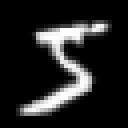
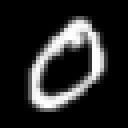
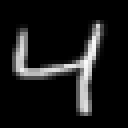
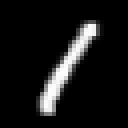
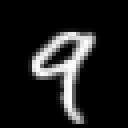
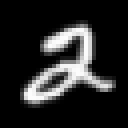
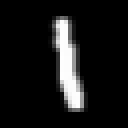
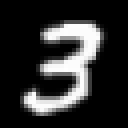
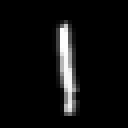
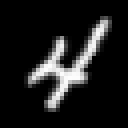

In [5]:
k = 1:10
[Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]

In [6]:
nz = 32
ngf = 16
nc = 1

# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

# Activation Layer
mutable struct Activation; f; end;

(a::Activation)(x) = a.f.(x)

# 2D Batch Normalization
mutable struct BatchNorm
    moments
    params
    nParameters
end

(b::BatchNorm)(x) = batchnorm(x, b.moments, b.params)

# BatchNorm(C) = BatchNorm(bnmoments(), array_type(bnparams(C)), 0)
BatchNorm(C) = BatchNorm(bnmoments(), param(array_type(bnparams(C))), 0)

moments = bnmoments(momentum = 0.1)
# Transposed Convolution Definition
struct DeConv; w; b; f; p; stride; padding; end

DeConv(w1::Int, w2::Int, cx::Int, cy::Int, f = identity; pdrop = 0, stride = 1, padding = 0) = 
DeConv(param(rand(Uniform(-sqrt(1/(cy * w1 * w2)),sqrt(1/(cy * w1 * w2))), w1,w2,cy,cx)), 
    param(rand(Uniform(-sqrt(1/(cy * w1 * w2)),sqrt(1/(cy * w1 * w2))), 1,1,cy,1)), f, pdrop, stride, padding)

(dc::DeConv)(x) = (deconv4(dc.w, dropout(x, dc.p), padding = dc.padding, stride = dc.stride, mode = 1) .+ dc.b)


# Encoder and Decoder Definitions
latent_dim = 32

Decoder = Chain(DeConv(4,4,nz, ngf * 4), 
                BatchNorm(ngf*4),
                Activation(Knet.elu),
                DeConv(4,4, ngf * 4, ngf * 2, stride = 2, padding = 1), 
                BatchNorm(ngf*2),
                Activation(Knet.elu),
                DeConv(4,4, ngf * 2, ngf, stride = 2, padding = 1), 
                BatchNorm(ngf),
                Activation(Knet.elu),
                DeConv(4,4, ngf, nc, stride = 2, padding = 1),
                Activation(Knet.sigm)
)

# Decoder2 = Chain(DeConv(4,4,nz, ngf * 4), 
#                 Activation(Knet.elu),
#                 DeConv(4,4, ngf * 4, ngf * 2, stride = 2, padding = 1), 
#                 Activation(Knet.elu),
#                 DeConv(4,4, ngf * 2, ngf, stride = 2, padding = 1), 
#                 Activation(Knet.elu),
#                 DeConv(4,4, ngf, nc, Knet.sigm, stride = 2, padding = 1))

# Decoder3 = Chain(BatchNorm(nz))

Chain((DeConv(P(KnetArray{Float32, 4}(4,4,64,32)), P(KnetArray{Float32, 4}(1,1,64,1)), identity, 0, 1, 0), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(Knet.KnetArrays.KnetVector{Float32}(128)), 0), Activation(Knet.Ops20.elu), DeConv(P(KnetArray{Float32, 4}(4,4,32,64)), P(KnetArray{Float32, 4}(1,1,32,1)), identity, 0, 2, 1), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(Knet.KnetArrays.KnetVector{Float32}(64)), 0), Activation(Knet.Ops20.elu), DeConv(P(KnetArray{Float32, 4}(4,4,16,32)), P(KnetArray{Float32, 4}(1,1,16,1)), identity, 0, 2, 1), BatchNorm(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(Knet.KnetArrays.KnetVector{Float32}(32)), 0), Activation(Knet.Ops20.elu), DeConv(P(KnetArray{Float32, 4}(4,4,1,16)), P(KnetArray{Float32, 4}(1,1,1,1)), identity, 0, 2, 1), Activation(Knet.Ops20.sigm)))

In [7]:
lr = 1e-3
n_epochs = 1

inner_loss(m, x, z) = mean(sum((m(z) - x).^2, dims = 3))
outer_loss(m, x,z) = mean(sum((m(z) - x).^2, dims = 3))

for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        # Encoding part
        origin = param(array_type(zeros(1, 1, nz, batch_size)))
        derivative_origin = @diff inner_loss(Decoder, x, origin)
        z = (-grad(derivative_origin, origin))
        
        AutoGrad.@zerograd inner_loss()
        # Decoding Part
        # g = Decoder(z)
        
        derivative_model = @diff outer_loss(Decoder, x, z)
        if (i-1) % 100 == 0
           println("Step $i  : ",value(derivative_model)) 
        end
        
        for p in Knet.params(Decoder)
            dp = grad(derivative_model, p)
            update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
#             update!(value(p), dp, Knet.SGD(lr = lr))
        end
    end
end

┣███████████████████▉┫ [100.00%, 1/1, 00:00/00:00, 700.59i/s] 

Step 1  : 0.20400538
Step 101  : 0.021093555
Step 201  : 0.014950242
Step 301  : 0.015648168
Step 401  : 0.010527998
Step 501  : 0.009284498
Step 601  : 0.009273469
Step 701  : 0.010275587
Step 801  : 0.008408855
Step 901  : 0.01019504


┣███████████████████▉┫ [100.00%, 1/1, 00:42/00:42, 41.60s/i] 


In [8]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, plot_size = (900,300))
    k = rand(1:64, n_instances)
    ori_plot_list = reshape(im_ori[:,:,:,k[1]], (32, 32))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (32, 32))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,:,:,j], (32, 32)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (32, 32)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = plot_size)
end

plot_reconstructed_images (generic function with 3 methods)

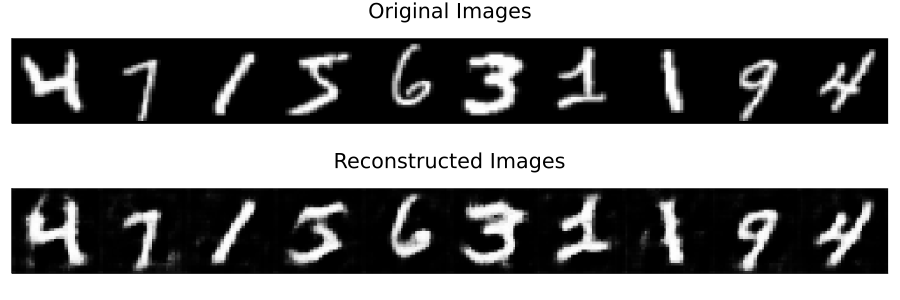

In [9]:
x = first(dtrn);

origin = param(array_type(zeros(1, 1, nz, batch_size));)
derivative_origin = @diff inner_loss(Decoder, x,origin)

z = (-grad(derivative_origin, origin))

im_rec = Decoder(z)

plot_reconstructed_images(x, im_rec, 10, (900,300))